In [1]:
import numpy as np
import polars as pl
import os
from pathlib import Path
from typing import List, Tuple, Union
from datetime import datetime, timedelta
from pydantic import BaseModel
from loguru import logger
from enum import Enum
import random


class EndStatus(Enum):
    DISSIPATED = 0
    MOVE_OUT_OF_RESPONSIBILITY = 1
    MERGED = 2
    NEARLY_STATIONARY = 3


class CycloneCategory(Enum):
    BELOW_TD_OR_UNKNOWN = 0
    TROPICAL_DEPRESSION = 1  # 热带低压 (TD, 10.8-17.1m/s)
    TROPICAL_STORM = 2  # 热带风暴 (TS, 17.2-24.4 m/s)
    SEVERE_TROPICAL_STORM = 3  # 强热带风暴 (STS, 24.5-32.6 m/s)
    TYPHOON = 4  # 台风 (TY, 32.7-41.4 m/s)
    SEVERE_TYPHOON = 5  # 强台风 (STY, 41.5-50.9 m/s)
    SUPER_TYPHOON = 6  # 超强台风 (SuperTY, ≥51.0 m/s)
    EXTRATROPICAL = 9  # 变性 (The change is complete)


class HurricaneHeader(BaseModel):
    data_type: int
    country_code: int
    data_count: int
    hurricane_code: int
    china_hurricane_code: int
    end_status: EndStatus
    time_interval_hr: int
    hurricane_name: str
    dataset_record_time: datetime


class HurricaneEntry(BaseModel):
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


class Hurricane(BaseModel):
    header: HurricaneHeader
    entries: List[HurricaneEntry]


script_folder = Path(os.getcwd())
dataset_folder = script_folder / "CMABSTdata"

# https://tcdata.typhoon.org.cn/zjljsjj.html
# example_file = dataset_folder / "CH2022BST.txt"
example_file = dataset_folder / "CH1950BST.txt"
logger.info(f"example_file: {example_file}")


def parse_header(line: str) -> HurricaneHeader:
    entry = line.split()
    data_type = int(entry[0])
    country_code = int(entry[1])
    data_count = int(entry[2])
    hurricane_code = int(entry[3])
    try:
        china_hurricane_code = int(entry[4])
    except ValueError:
        # might be a tuple (a,b)
        codes = entry[4].split(",")
        china_hurricane_code = int(codes[0])
    hurricane_end_enum = int(entry[5])
    end_status = EndStatus(hurricane_end_enum)
    time_interval_hr = int(entry[6])
    hurricane_name = entry[7]
    dataset_record_time = entry[8]
    time_format = "%Y%m%d"
    dataset_record_time = datetime.strptime(dataset_record_time, time_format)
    return HurricaneHeader(data_type=data_type,
                           country_code=country_code,
                           data_count=data_count,
                           hurricane_code=hurricane_code,
                           china_hurricane_code=china_hurricane_code,
                           end_status=end_status,
                           time_interval_hr=time_interval_hr,
                           hurricane_name=hurricane_name,
                           dataset_record_time=dataset_record_time)


def parse_entry(line: str) -> HurricaneEntry:
    entry = line.split()
    date_str = entry[0]
    time_format = "%Y%m%d%H"
    date = datetime.strptime(date_str, time_format)
    category = int(entry[1])
    hurricane_category = CycloneCategory(category)
    latitude = float(int(entry[2])) / 10.0
    longitude = float(int(entry[3])) / 10.0
    # in hPa
    lowest_pressure = int(entry[4])
    # 2分钟平均近中心最大风速(MSW, m/s)
    # WND=9 表示 MSW < 10m/s,
    # WND=0 为缺测
    wind_speed = int(entry[5])
    # not sure about OWD
    return HurricaneEntry(date=date,
                          category=hurricane_category,
                          latitude=latitude,
                          longitude=longitude,
                          lowest_pressure=lowest_pressure,
                          wind_speed=wind_speed)


def parse_dataset(filename: str | Path):
    hurricanes: list[Hurricane] = []
    with open(filename, "r") as f:
        try:
            while True:
                # check if the line is empty
                l = f.readline()
                if not l:
                    break
                header = parse_header(l)
                count = header.data_count
                hurricane_entries = []
                for i in range(count):
                    entry = parse_entry(f.readline())
                    hurricane_entries.append(entry)
                hurricane = Hurricane(header=header, entries=hurricane_entries)
                hurricanes.append(hurricane)
        except ValueError as e:
            logger.error(f"ValueError: {e} for {filename}")
        except IndexError as e:
            logger.warning(f"IndexError: {e} for {filename}")
        except EOFError:
            logger.info(f"EOFError for {filename}")
    return hurricanes



2024-03-20 11:39:29.997 | INFO     | __main__:<module>:63 - example_file: /home/crosstyan/Code/hurricane_stuff/CMABSTdata/CH1950BST.txt


In [2]:
total_dataset: list[Hurricane] = []

for file in dataset_folder.glob("*.txt"):
    hurricanes = parse_dataset(file)
    total_dataset.extend(hurricanes)

logger.info(f"total_dataset: {len(total_dataset)}")

2024-03-20 11:39:30.986 | INFO     | __main__:<module>:7 - total_dataset: 2469


In [3]:
class FlatHurricaneEntry(BaseModel):
    sample_id: int
    name: str
    china_hurricane_code: int
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


def flat_hurricane_entries(
        hurricanes: list[Hurricane]) -> List[FlatHurricaneEntry]:
    counter = 0
    def flat_one(h: Hurricane, counter: int = counter):
        name = h.header.hurricane_name
        hurricane_code = h.header.hurricane_code
        entries = h.entries
        return [
            FlatHurricaneEntry(sample_id=counter,
                               name=name,
                               china_hurricane_code=hurricane_code,
                               date=e.date,
                               category=e.category,
                               latitude=e.latitude,
                               longitude=e.longitude,
                               lowest_pressure=e.lowest_pressure,
                               wind_speed=e.wind_speed) for e in entries
        ]

    entries = []
    for h in hurricanes:
        entries.extend(flat_one(h, counter))
        counter += 1
    return entries


flatten_entries = [
    e.model_dump() for e in flat_hurricane_entries(total_dataset)
]


def entry_enum_to_number(entry: dict[str, any]) -> dict[str, any]:
    entry['category'] = entry['category'].value
    return entry


flatten_entries_without_enum = [
    entry_enum_to_number(e) for e in flatten_entries
]

In [4]:
df = pl.DataFrame(flatten_entries_without_enum)

In [5]:
df.describe()

statistic,sample_id,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,f64,str,f64,str,f64,f64,f64,f64,f64
"""count""",71705.0,"""71705""",71705.0,"""71705""",71705.0,71705.0,71705.0,71705.0,71705.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",1238.613332,null,17.650066,"""1983-09-15 19:…",2.821588,20.902251,134.228423,986.340004,23.758218
"""std""",712.786331,null,10.47291,null,2.330128,9.283707,16.616481,20.931241,15.36339
"""min""",0.0,"""(nameless)""",1.0,"""1949-01-13 00:…",0.0,0.5,95.0,870.0,0.0
"""25%""",621.0,null,9.0,"""1965-09-21 06:…",1.0,14.2,121.8,980.0,15.0
"""50%""",1234.0,null,17.0,"""1981-08-21 00:…",2.0,19.3,132.5,995.0,20.0
"""75%""",1869.0,null,25.0,"""2001-09-03 06:…",4.0,25.8,145.0,1001.0,33.0
"""max""",2468.0,"""Zola""",53.0,"""2022-12-13 06:…",9.0,70.1,243.9,1022.0,110.0


In [6]:
df_filtered = df.filter(df["wind_speed"] != 0)
df_filtered.describe()

statistic,sample_id,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,f64,str,f64,str,f64,f64,f64,f64,f64
"""count""",65796.0,"""65796""",65796.0,"""65796""",65796.0,65796.0,65796.0,65796.0,65796.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",1307.737796,null,17.502265,"""1985-09-05 05:…",2.866664,20.73495,133.459558,984.894963,25.891893
"""std""",699.270657,null,10.381192,null,2.121499,8.752285,16.292624,21.13435,14.21218
"""min""",0.0,"""(nameless)""",1.0,"""1949-01-15 00:…",0.0,0.5,95.0,870.0,8.0
"""25%""",731.0,null,9.0,"""1968-06-01 00:…",1.0,14.5,121.2,975.0,15.0
"""50%""",1337.0,null,17.0,"""1984-10-31 00:…",2.0,19.4,131.7,992.0,20.0
"""75%""",1918.0,null,25.0,"""2003-06-17 18:…",4.0,25.5,143.9,1000.0,35.0
"""max""",2468.0,"""Zola""",53.0,"""2022-12-13 06:…",9.0,70.1,243.9,1016.0,110.0


<Axes: ylabel='Count'>

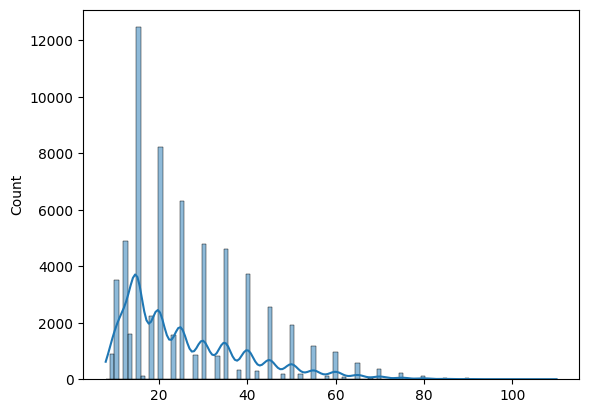

In [7]:
import seaborn as sns

sns.histplot(df_filtered["wind_speed"], kde=True)

In [8]:
import torch

# check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"device: {device}")

2024-03-20 11:39:34.405 | INFO     | __main__:<module>:5 - device: cuda


In [9]:
import math
time = df["date"][6]
assert isinstance(time, datetime)
# use sin/cos to normalize the day in a year and the hour in a day

def sinusoidal_hour_in_day(dt: datetime) -> tuple[float, float]:
    """
    Return sin and cos corresponding to the hour of day from a datetime object.
    """
    # Extract the hour from the datetime object
    hour = dt.hour

    # Calculate the radians for the given hour
    radians_per_hour = 2 * math.pi / 24
    hour_in_radians = hour * radians_per_hour

    # Return the sine and cosine values
    return math.sin(hour_in_radians), math.cos(hour_in_radians)

def sinusoidal_day_in_year(dt: datetime) -> tuple[float, float]:
    """
    Return sin and cos corresponding to the day of year from a datetime object.
    """
    # Extract the day of year from the datetime object
    day_of_year = dt.timetuple().tm_yday

    # Handle leap years
    year_length = 366 if dt.year % 4 == 0 and (dt.year % 100 != 0 or dt.year % 400 == 0) else 365

    # Calculate the radians for the given day of year
    radians_per_day = 2 * math.pi / year_length
    day_in_radians = day_of_year * radians_per_day

    # Return the sine and cosine values
    return math.sin(day_in_radians), math.cos(day_in_radians)

logger.info(f"{time} -> {sinusoidal_hour_in_day(time)} {sinusoidal_day_in_year(time)}")

2024-03-20 11:39:34.415 | INFO     | __main__:<module>:37 - 1949-01-14 12:00:00 -> (1.2246467991473532e-16, -1.0) (0.2386727660059501, 0.9711000518829505)


In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# longitude and latitude
lat_long_scaler = MinMaxScaler()
latitude = lat_long_scaler.fit_transform(df_filtered["latitude"].to_numpy().reshape(-1, 1)).reshape(-1)
longitude = lat_long_scaler.fit_transform(df_filtered["longitude"].to_numpy().reshape(-1, 1)).reshape(-1)

# wind speed
wind_scaler = StandardScaler()
wind_speed = wind_scaler.fit_transform(df_filtered["wind_speed"].to_numpy().reshape(-1, 1)).reshape(-1)

# lowest pressure
lowest_pressure_scaler = StandardScaler()
lowest_pressure = lowest_pressure_scaler.fit_transform(df_filtered["lowest_pressure"].to_numpy().reshape(-1, 1)).reshape(-1)

In [11]:
with_normalized_time = df_filtered.with_columns([
    df_filtered["date"].map_elements(lambda x: sinusoidal_day_in_year(x)[0]).alias("sin_day_in_year"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_day_in_year(x)[1]).alias("cos_day_in_year"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_hour_in_day(x)[0]).alias("sin_hour_in_day"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_hour_in_day(x)[1]).alias("cos_hour_in_day"),
    pl.Series("latitude_norm", latitude),
    pl.Series("longitude_norm", longitude),
    pl.Series("wind_speed_norm", wind_speed),
    pl.Series("lowest_pressure_norm", lowest_pressure),
])

df_features = with_normalized_time.select([
    "sample_id",
    "sin_day_in_year",
    "cos_day_in_year",
    "sin_hour_in_day",
    "cos_hour_in_day",
    "latitude_norm",
    "longitude_norm",
    "wind_speed_norm",
    "lowest_pressure_norm",
])

In [12]:
df_features.describe()

statistic,sample_id,sin_day_in_year,cos_day_in_year,sin_hour_in_day,cos_hour_in_day,latitude_norm,longitude_norm,wind_speed_norm,lowest_pressure_norm
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",65796.0,65796.0,65796.0,65796.0,65796.0,65796.0,65796.0,65796.0,65796.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1307.737796,-0.498177,-0.264362,0.006157,0.003637,0.290732,0.258291,7.5743e-17,-2.4023e-16
"""std""",699.270657,0.550623,0.615432,0.705854,0.708332,0.125751,0.10942,1.000008,1.000008
"""min""",0.0,-0.999991,-1.0,-1.0,-1.0,0.0,0.0,-1.258922,-5.43645
"""25%""",731.0,-0.927542,-0.809017,0.0,-0.707107,0.201149,0.175957,-0.766383,-0.468197
"""50%""",1337.0,-0.699458,-0.413279,1.2246e-16,6.1232e-17,0.271552,0.246474,-0.41457,0.336187
"""75%""",1918.0,-0.263665,0.209315,1.0,1.0,0.359195,0.328408,0.640871,0.71472
"""max""",2468.0,0.999991,1.0,1.0,1.0,1.0,1.0,5.918075,1.471788


In [13]:
df_features.height

65796

In [14]:
from numpy.typing import NDArray
from functools import reduce
# group by sample_id and iterate over the groups
grouped = df_features.group_by("sample_id")
from typing import Iterable, Iterator, Tuple, Union

EXPECTED_TIMESTAMP_COUNT = 20


def filter_out_short_sequence(id_and_df: tuple[int, pl.DataFrame]) -> bool:
    return id_and_df[1].height >= EXPECTED_TIMESTAMP_COUNT


def pad_or_truncate(
        id_and_df: tuple[int, pl.DataFrame]) -> tuple[pl.Series, pl.DataFrame]:
    group_id, df = id_and_df
    if df.height < EXPECTED_TIMESTAMP_COUNT:
        # pad with zeros
        diff = EXPECTED_TIMESTAMP_COUNT - df.height
        mask = pl.Series("mask", [True] * df.height + [False] * diff)
        zeros = pl.DataFrame({
            "sample_id": [group_id] * diff,
            "sin_day_in_year": [0.0] * diff,
            "cos_day_in_year": [0.0] * diff,
            "sin_hour_in_day": [0.0] * diff,
            "cos_hour_in_day": [0.0] * diff,
            "latitude_norm": [0.0] * diff,
            "longitude_norm": [0.0] * diff,
            "wind_speed_norm": [0.0] * diff,
            "lowest_pressure_norm": [0.0] * diff,
        })
        stacked = df.vstack(zeros)
        # sort by date
        return mask, stacked.sort("date")
    elif df.height >= EXPECTED_TIMESTAMP_COUNT:
        # truncate
        mask = pl.Series("mask", [True] * EXPECTED_TIMESTAMP_COUNT)
        return mask, df.head(EXPECTED_TIMESTAMP_COUNT)
    else:
        mask = pl.Series("mask", [True] * df.height)
        return mask, df


filtered = filter(filter_out_short_sequence, grouped)
padded = map(pad_or_truncate, filtered)


# for some reason, the reduce function is not working
def to_tensor(
        id_and_df: Iterable[tuple[int,
                                  pl.DataFrame]]) -> tuple[NDArray, NDArray]:
    init_mask, init_data = np.empty(
        (0, EXPECTED_TIMESTAMP_COUNT, 1)), np.empty(
            (0, EXPECTED_TIMESTAMP_COUNT, df_features.width))
    for mask, df in id_and_df:
        current_data = df.to_numpy()
        current_mask = np.expand_dims(mask.to_numpy(), axis=-1)
        try:
            new_data = np.vstack(
                (init_data, np.expand_dims(current_data, axis=0)))
            new_mask = np.vstack(
                (init_mask, np.expand_dims(current_mask, axis=0)))
        except ValueError as e:
            logger.error(f"ValueError: {e}")
            logger.info(
                f"init_data: {init_data.shape}, current_data: {current_data.shape}"
            )
            logger.info(
                f"init_mask: {init_mask.shape}, current_mask: {current_mask.shape}"
            )
            logger.info(
                f"init_data: {init_data}, current_data: {current_data}")
            logger.info(
                f"init_mask: {init_mask}, current_mask: {current_mask}")

        init_data, init_mask = new_data, new_mask
    return init_data, init_mask


data_with_id, mask = to_tensor(padded)
# remove the sample_id column
features = data_with_id[:, :, 1:]
display((features.shape, mask.shape))

# y_train should be the last 4 features
y_train = features[:, -10:, -4:]
X_train = features[:, :10, :]
display((X_train.shape, y_train.shape))

/tmp/ipykernel_840939/1895117370.py:44: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['sample_id'])`.
  filtered = filter(filter_out_short_sequence, grouped)


((1599, 20, 8), (1599, 20, 1))

((1599, 10, 8), (1599, 10, 4))

In [15]:
# one hot encoding for category
# with sklearn
from sklearn.preprocessing import OneHotEncoder
category = df_filtered["category"].to_numpy()
category = category.reshape(-1, 1)
encoder = OneHotEncoder()
category = encoder.fit_transform(category)
display(category.shape)
# get the count of each category
category_count = df_filtered.group_by("category").len()
display(category_count)

(65796, 8)

category,len
i64,u32
5,4945
0,4133
3,11435
2,11125
9,3165
1,17650
6,3914
4,9429


In [16]:
# get the average count of samples per hurricane (by sample_id)
average_samples_per_hurricane = df_features.group_by("sample_id").agg(pl.col("sample_id").count().alias("count")).select("count")
average_samples_per_hurricane.describe()

statistic,count
str,f64
"""count""",2469.0
"""null_count""",0.0
"""mean""",26.648846
"""std""",14.383362
"""min""",1.0
"""25%""",15.0
"""50%""",25.0
"""75%""",36.0
"""max""",97.0


<Axes: ylabel='Count'>

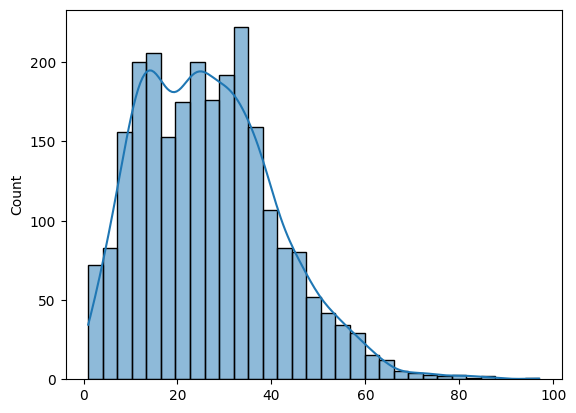

In [17]:
sns.histplot(average_samples_per_hurricane["count"], kde=True)

In [18]:
import tensorflow as tf
logger.info(tf.config.list_physical_devices("GPU"))

2024-03-20 11:39:36.254912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 11:39:37.224033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-20 11:39:37.748 | INFO     | __main__:<module>:2 - [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2024-03-20 11:39:37.747124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 11:39:37.748458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] success

In [19]:
from keras import backend as K

display(K.backend())

'tensorflow'

In [26]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Masking, Dropout, GRU, Bidirectional
from keras.optimizers import AdamW, Lion

dim_timesteps = X_train.shape[1]
dim_features = X_train.shape[2]
dim_output_features = y_train.shape[2]
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(dim_timesteps, dim_features)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    Bidirectional(GRU(16, return_sequences=True)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(dim_output_features, activation="linear"),
])

model.compile(optimizer=Lion(learning_rate=0.0015), loss="mean_squared_error")
model.summary()

/home/crosstyan/.conda/envs/cross/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 10, 32)         │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10, 64)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10, 4)          │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,276 (149.52 KB)

 Trainable params: 38,276 (149.52 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="hurricane_lstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1
)
history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.2, callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.6545
Epoch 1: val_loss improved from inf to 0.54193, saving model to hurricane_lstm.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.6597 - val_loss: 0.5419
Epoch 2/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5265
Epoch 2: val_loss improved from 0.54193 to 0.49669, saving model to hurricane_lstm.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5530 - val_loss: 0.4967
Epoch 3/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6730
Epoch 3: val_loss improved from 0.49669 to 0.46927, saving model to hurricane_lstm.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5774 - val_loss: 0.4693
Epoch 4/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5873
Epoch 4: val_loss improved from 0.46927 to 0.44338, saving model to hurricane_lstm.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5155 - val_loss: 0.4434
Epoch 5/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4725
Epoch 5: val_loss improved from 0.443

In [22]:

# use the model to predict the next 10 time steps
# use the last 10 time steps from the training set
X_test = X_train[-1, :, :]
X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
X_test.shape

(1, 10, 8)

In [23]:
y_pred = model.predict(X_test)
y_pred.shape
# reverse the normalization
wind_pred = wind_scaler.inverse_transform(y_pred[:, :, 2])
pressure_pred = lowest_pressure_scaler.inverse_transform(y_pred[:, :, 3])
lat_pred = lat_long_scaler.inverse_transform(y_pred[:, :, 0])
long_pred = lat_long_scaler.inverse_transform(y_pred[:, :, 1])
# display((wind_pred, pressure_pred, lat_pred, long_pred))
pred = np.vstack((lat_pred, long_pred, pressure_pred, wind_pred)).T
display(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


array([[133.28067 , 138.04439 , 969.8505  ,  37.558186],
       [134.43597 , 140.02562 , 968.56177 ,  38.06454 ],
       [133.16565 , 138.69261 , 974.08514 ,  33.985302],
       [134.01442 , 132.767   , 979.3082  ,  30.592905],
       [136.88528 , 128.45422 , 983.3507  ,  27.989304],
       [136.95135 , 128.44997 , 985.59796 ,  26.456995],
       [136.14777 , 123.73232 , 986.22565 ,  25.819372],
       [135.21445 , 121.55591 , 984.711   ,  27.175379],
       [137.74936 , 119.73177 , 976.4964  ,  32.350407],
       [141.50917 , 118.10136 , 971.5906  ,  34.105812]], dtype=float32)